# Introduction

**In this competition we have to build a model that will automatically discriminate malignant from benign lesions in breast ultrasound (US) studies.**
 
**So let's take a plan:**

<ul>
    <a href='#1'><li>Import libraries and data</li></a>
    <a href='#2'><li>Data preprocessing</li></a>
    <a href='#3'><li>Data analysis</li></a>
    <a href='#4'><li>Resize and prepare images to the model</li></a>
    <a href='#5'><li>Creating the model</li></a>
    <a href='#6'><li>Model fitting</li></a>
    <a href='#7'><li>Test data preparation</li></a>
    <a href='#8'><li>Making predictions</li></a>
</ul>

<p id='1'><h3><b>Import libraries and data</b></h3></p>

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.io import imread
import random
import cv2
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, SeparableConv2D, RandomFlip, RandomRotation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
train_dir = Path('/kaggle/input/iuss-mlh-2023/training_set')

train_benign_dir = train_dir / 'benign'
train_malignant_dir = train_dir / 'malignant'

In [3]:
cases_benign = train_benign_dir.glob('*.png')
cases_malignant = train_malignant_dir.glob('*.png')

train_data = []

for img in cases_benign:
    if "mask" not in str(img):
        train_data.append((img,0))
        
for img in cases_malignant:
    if "mask" not in str(img):
        train_data.append((img,1))
        
train_data = pd.DataFrame(train_data, columns=['image', 'label'], index=None)
train_data = train_data.sample(frac=1.).reset_index(drop=True)

train_data

,image,label
0,/kaggle/input/iuss-mlh-2023/training_set/malig...,1
1,/kaggle/input/iuss-mlh-2023/training_set/benig...,0
2,/kaggle/input/iuss-mlh-2023/training_set/malig...,1
3,/kaggle/input/iuss-mlh-2023/training_set/malig...,1
4,/kaggle/input/iuss-mlh-2023/training_set/benig...,0
...,...,...
542,/kaggle/input/iuss-mlh-2023/training_set/benig...,0
543,/kaggle/input/iuss-mlh-2023/training_set/benig...,0
544,/kaggle/input/iuss-mlh-2023/training_set/benig...,0
545,/kaggle/input/iuss-mlh-2023/training_set/benig...,0


* Let's show several examples of the images we have to see if we collected passes right.

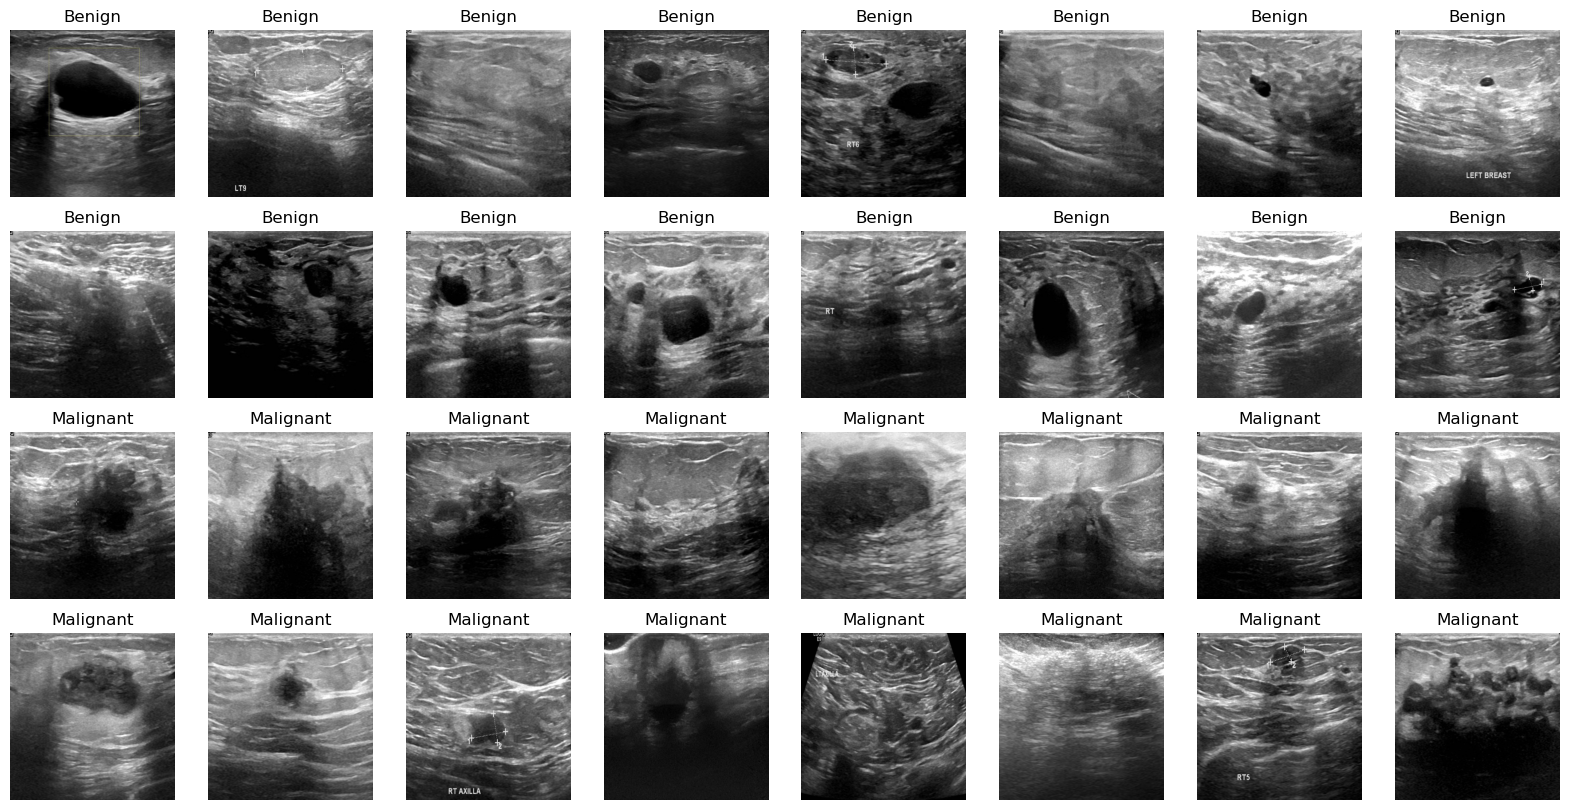

In [4]:
def plot_images(data, rows: int, cols: int, figsize: tuple, show_label=True):
    count = 0
    f, ax = plt.subplots(rows, cols, figsize=figsize)
    
    cases_benign = data[data['label']==0]
    cases_malignant = data[data['label']==1]
    images = []
    for i in random.sample(range(0, cases_benign.shape[0]), rows*cols//2):
        images.append(imread(cases_benign.iloc[i]['image']))
    for j in random.sample(range(0, cases_malignant.shape[0]), rows*cols-rows*cols//2):
        images.append(imread(cases_malignant.iloc[j]['image']))
        
    for img in images:
        ax[count//cols, count%cols].imshow(img, cmap='gray')
        if show_label:
            if count < rows*cols//2:
                ax[count//cols, count%cols].set_title("Benign")
            else:
                ax[count//cols, count%cols].set_title("Malignant")
                
        ax[count//cols, count%cols].axis('off')
        ax[count//cols, count%cols].set_aspect('auto')
        count += 1
        
    plt.show()
    
plot_images(train_data, 4, 8, (20,10))

<p id='2'><h3><b>Data preprocessing</b></h3></p>

* Just a function to apply mask on image and get only that part of image which is masked

In [5]:
def apply_mask(image, mask):
    # Convert to numpy arrays
    image = np.array(image)
    mask = np.array(mask)
    # Convert grayscale image to RGB
    mask = np.stack((mask,)*3, axis=-1)
    # Multiply arrays
    result = image*mask
    return result

* In the next part of code I will apply masks for the images. Here I'm looking for images and for every one I find it's masks (it can be several ones), apply them and save the results.

In [6]:
#define a folder path where I will write data
global_path = '/kaggle/working'

training_path = os.path.join(global_path, "training_set")
if not os.path.exists(training_path): os.mkdir(training_path)

train_benign_path = os.path.join(training_path, "benign")
if not os.path.exists(train_benign_path): os.mkdir(train_benign_path)  
    
train_malignant_path = os.path.join(training_path, "malignant")
if not os.path.exists(train_malignant_path): os.mkdir(train_malignant_path)


def save_masked_images(img_directory, final_directory):
    images = img_directory.glob('*.png')
    index = 1
    for img in images:
        if "mask" not in str(img):
            img_mask = Path(str(img)[:-4] + '_mask.png')
            try:
                res = apply_mask(Image.open(img), Image.open(img_mask))
                res = Image.fromarray(res)
                res.save(f'{final_directory}/picture{index}.png')
            except Exception as e:
                print("Have problems with the", str(img_mask))
                print("Error:", e)

            index += 1
            i = 1
            while True:
                if Path(str(img_mask)[:-4] + '_' + str(i) + '.png').is_file():
                    try:
                        res = apply_mask(Image.open(img), Image.open(str(img_mask)[:-4] + '_' + str(i) + '.png'))
                        res = Image.fromarray(res)
                        res.save(f'{final_directory}/picture{index}_{i}.png')
                    except Exception as e:
                        print("Have problems with the", str(img_mask)[:-4] + '_' + str(i))
                        print("Error:", e)

                    i += 1
                else:
                    break
                    
save_masked_images(train_benign_dir, train_benign_path)
save_masked_images(train_malignant_dir, train_malignant_path)

Have problems with the /kaggle/input/iuss-mlh-2023/training_set/benign/benign (54)_mask_1
Error: operands could not be broadcast together with shapes (468,616,3) (468,616,4,3) 
Have problems with the /kaggle/input/iuss-mlh-2023/training_set/benign/benign (4)_mask_1
Error: operands could not be broadcast together with shapes (465,555,3) (465,555,4,3) 


* We have already applied masks on images to get only images of lesions in our directory. Now we have all that we want and we can start to analyze our data.

* Firstly, let's collect all our images with their labels in one dataframe.

In [7]:
cases_benign = Path(train_benign_path).glob('*.png')
cases_malignant = Path(train_malignant_path).glob('*.png')

data = []

for img in cases_benign: data.append((img,'benign'))      
for img in cases_malignant: data.append((img,'malignant'))
        
data = pd.DataFrame(data, columns=['image', 'label'], index=None)
data = data.sample(frac=1.).reset_index(drop=True)

data

,image,label
0,/kaggle/working/training_set/benign/picture7_1...,benign
1,/kaggle/working/training_set/benign/picture41.png,benign
2,/kaggle/working/training_set/benign/picture235...,benign
3,/kaggle/working/training_set/benign/picture256...,benign
4,/kaggle/working/training_set/benign/picture320...,benign
...,...,...
558,/kaggle/working/training_set/benign/picture67.png,benign
559,/kaggle/working/training_set/malignant/picture...,malignant
560,/kaggle/working/training_set/benign/picture37.png,benign
561,/kaggle/working/training_set/benign/picture93.png,benign


<p id='3'><h3><b>Data analysis</b></h3></p>

* Let's get the distribution of values of 'label' class
* And then plot it.

benign       402
malignant    161
Name: label, dtype: int64


Text(0.5, 1.0, 'Label distribution')

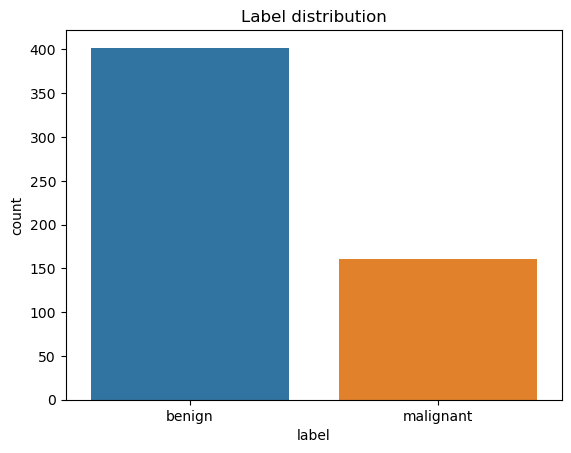

In [8]:
print(data['label'].value_counts())

sns.countplot(x = data['label'])
plt.title("Label distribution")

* We can see that our data is imbalanced. There are much more 'benign' cases than 'malignant'. It is important for our future model building.

* Let's encode the labels

In [9]:
data['label'].replace("malignant", 1, inplace=True)
data['label'].replace("benign", 0, inplace=True)

print(data['label'].value_counts())

0    402
1    161
Name: label, dtype: int64


* We can't be sure that we did everything right until we see some examples of our data that we have written to the directory.

* So, let's show several random examples of benign/malignant images.

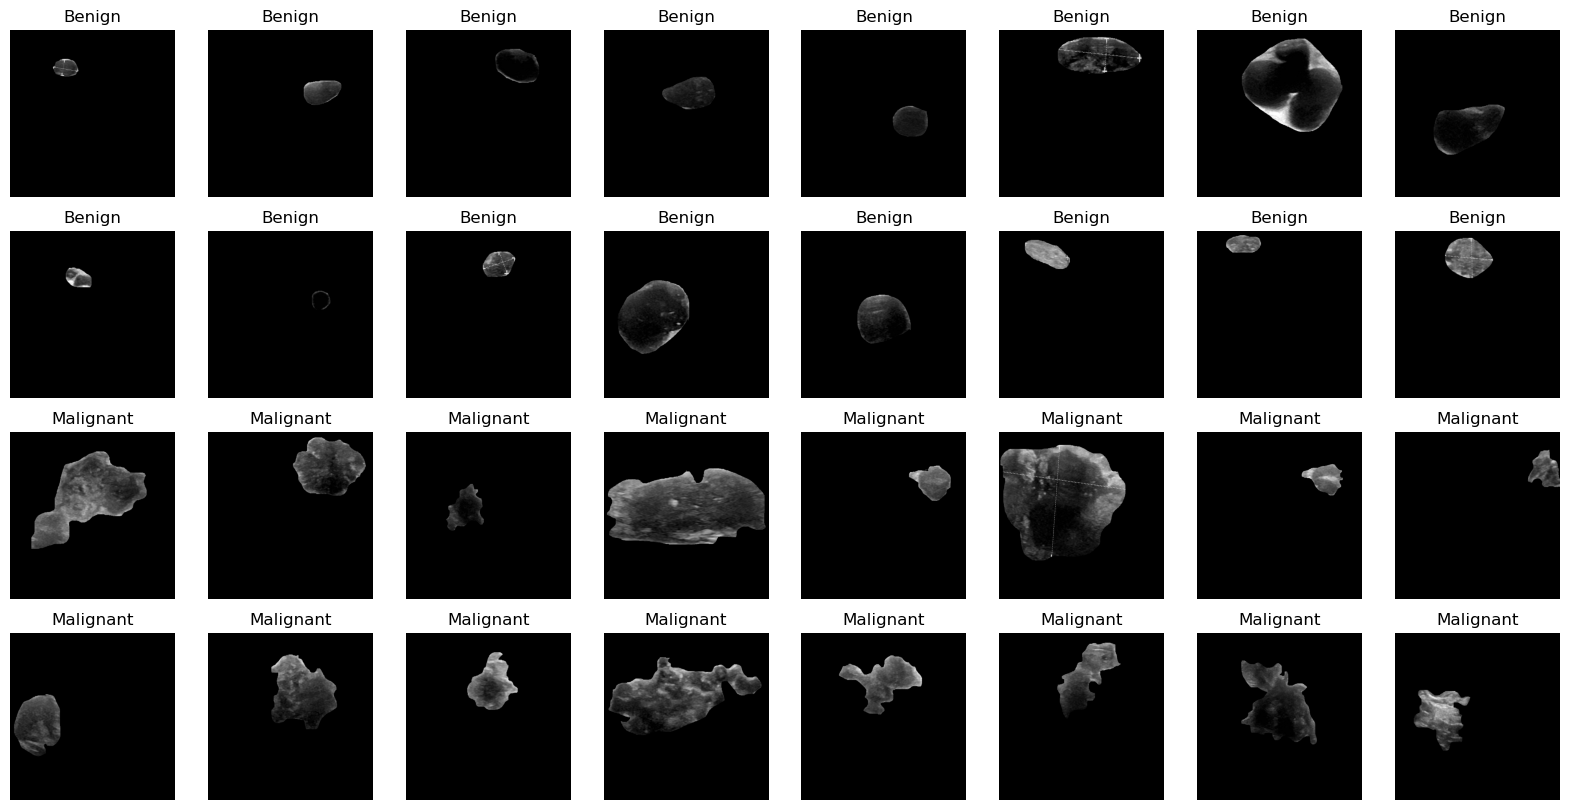

In [10]:
plot_images(data, 4, 8, (20,10))

<p id='4'><h3><b>Resize and prepare images to the model</b></h3></p>

* Seems like we did everything right. Benign lesions look a bit different than malignant, the're smoother, as I can see. But that will be the task for deep learning model.

* To prepare our images before modeling we need to resize them all to one size. Let it be (224, 224, 3), and I'll explain that later. And, of course, don't forget about scaling!

In [11]:
data_list = []
labels_list = []

# loop over the image paths
for i in range(data.shape[0]):
    # extract the class label from the filename, load the image, and
    # resize it to be a fixed 224x224 pixels, ignoring aspect ratio
    image = cv2.imread(str(data.iloc[i]['image']))
    image = cv2.resize(image, (224, 224))
    data_list.append(image)
    labels_list.append(data.iloc[i]['label'])

labels_list = np.array(labels_list, dtype='float32')   
data_list = np.array(data_list, dtype="float32") / 255.0

<p id='5'><h3><b>Creating the model</b></h3></p>

* Because we have only a little bit of data, it's better way not to train our model from scratch and use some pre-trained weights from famous model. I'll use VGG-16 model.

* In the code below I'm downloading the VGG-16 model without top layers.

In [12]:
vgg_model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_shape=(224, 224, 3))

vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

* Now you see why I have resized all the images to (224, 224, 3). I have tried different ways to use pre-trained layers and finally I decided to use pre-trained weights only from first two layers.

In [13]:
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['block2_pool'].output

#Data augmentation
x = RandomFlip("horizontal")(x)
x = RandomRotation(0.2)(x)

#Main architecture
x = Conv2D(256, (3,3), activation='relu')(x)
x = Conv2D(256, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(512, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(512, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(512, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(1, activation='sigmoid')(x)

#Creating model
custom_model = Model(inputs=vgg_model.input, outputs=x)

#Make layers from VGG-16 non-trainable
for layer in custom_model.layers[:7]:
    layer.trainable = False

#Finally compile the model
custom_model.compile(loss='binary_crossentropy',
                     optimizer=Adam(learning_rate=1e-5),
                     metrics=['accuracy', AUC()])

In [14]:
#Let's look at our model
custom_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<p id='6'><h3><b>Model fitting</b></h3></p>

* We have only few actions left.

* Firstly, we're splitting our data on the train and test parts.

* Then because of huge imbalance of our data we need to set class weights as balanced. Otherwise, model won't work as wee want.

* And then finally let's fit it!

In [15]:
batch_size = 8
nb_epochs = 60

(X_train, X_test, y_train, y_test) = train_test_split(data_list, labels_list,
                                                      test_size=0.25, random_state=42)


class_weight = compute_class_weight(class_weight = 'balanced',
                                    classes = np.unique(np.ravel(labels_list, order='C')),
                                    y = np.ravel(labels_list, order='C'))

class_weight = dict(zip(np.unique(labels_list), class_weight))

#checkpoint_filepath = '/kaggle/working/best_model'
#chkpt = ModelCheckpoint(filepath=checkpoint_filepath, mode='max', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

history = custom_model.fit(X_train, y_train,
              validation_data = (X_test, y_test),
              #callbacks=[chkpt],
              batch_size=batch_size, steps_per_epoch = len(X_train) // batch_size,
              epochs = nb_epochs, class_weight=class_weight,
                           verbose=1)

Epoch 1/60
52/52 [==============================] - 28s 119ms/step - loss: 1.2416 - accuracy: 0.5505 - auc: 0.5261 - val_loss: 0.9513 - val_accuracy: 0.3546 - val_auc: 0.7444
Epoch 2/60
52/52 [==============================] - 5s 72ms/step - loss: 1.1836 - accuracy: 0.5676 - auc: 0.5837 - val_loss: 0.9344 - val_accuracy: 0.4326 - val_auc: 0.7479
Epoch 3/60
52/52 [==============================] - 4s 72ms/step - loss: 1.0828 - accuracy: 0.6135 - auc: 0.6284 - val_loss: 0.9235 - val_accuracy: 0.4752 - val_auc: 0.7643
Epoch 4/60
52/52 [==============================] - 4s 68ms/step - loss: 1.0692 - accuracy: 0.6135 - auc: 0.6286 - val_loss: 0.9520 - val_accuracy: 0.4894 - val_auc: 0.7748
Epoch 5/60
52/52 [==============================] - 4s 77ms/step - loss: 1.0261 - accuracy: 0.6643 - auc: 0.6748 - val_loss: 0.9296 - val_accuracy: 0.5603 - val_auc: 0.7948
Epoch 6/60
52/52 [==============================] - 4s 72ms/step - loss: 0.9015 - accuracy: 0.6618 - auc: 0.6928 - val_loss: 1.0160 -

* Let's plot the changes of train and test accuracy and losses

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


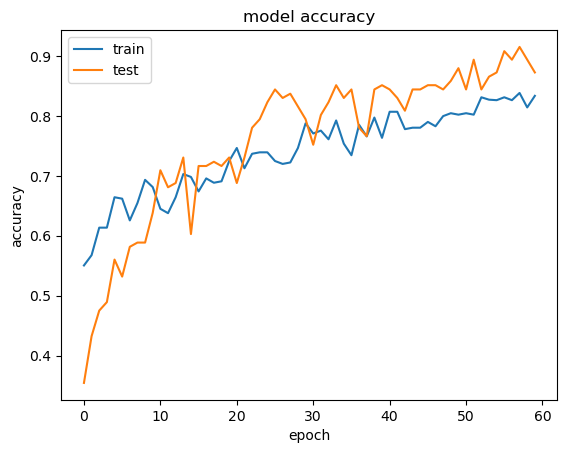

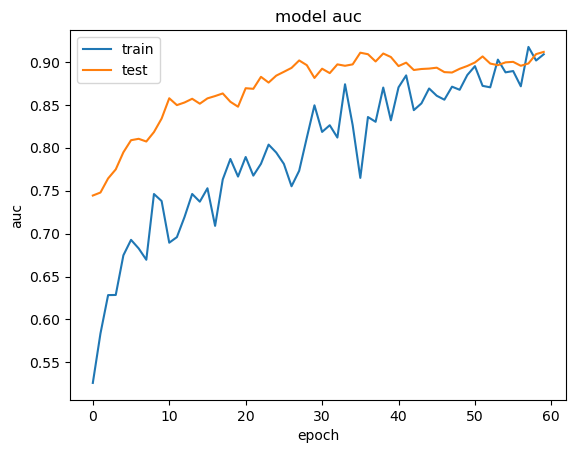

In [16]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

* Looks like charts started to diverge a little at the end. Maybe you can try different dropout parameters and larger number of epochs to get a better result. We have saved the model with the best performance on the auc score anyway.

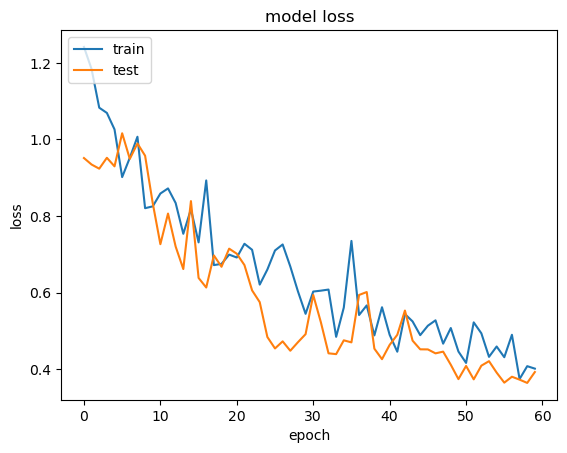

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

* We also can see the same picture at the losses chart.

In [18]:
score, acc, *is_anything_else_being_returned = custom_model.evaluate(X_test, y_test)

print('Test score:', score)
print('Test accuracy:', acc)

5/5 [==============================] - 8s 669ms/step - loss: 0.3923 - accuracy: 0.8723 - auc: 0.9117
Test score: 0.39226093888282776
Test accuracy: 0.8723404407501221


* And let's show the confusion matrix on the validation data.

In [19]:
y_pred = custom_model.predict(X_test, batch_size=8, verbose=1)
y_pred

18/18 [==============================] - 1s 31ms/step


array([[7.6142184e-02],
       [7.6075506e-01],
       [3.2483384e-02],
       [3.5923971e-03],
       [2.6527137e-01],
       [1.2260455e-02],
       [1.3936895e-01],
       [9.9837047e-01],
       [7.4235654e-01],
       [9.9838769e-01],
       [3.6835999e-03],
       [1.7330436e-03],
       [5.3806594e-03],
       [1.8553436e-02],
       [4.2189147e-02],
       [1.9325804e-02],
       [6.6886800e-03],
       [9.9988842e-01],
       [9.3159783e-01],
       [3.0637449e-02],
       [9.6040118e-01],
       [3.3637777e-01],
       [9.5257694e-03],
       [2.4956167e-03],
       [4.1748551e-03],
       [1.3846618e-01],
       [9.6806884e-01],
       [1.6734375e-01],
       [9.9947602e-01],
       [2.1872956e-02],
       [1.4897670e-01],
       [9.9029177e-01],
       [9.9485260e-01],
       [9.5884323e-01],
       [1.3877407e-01],
       [9.7762188e-04],
       [1.2132954e-02],
       [6.0105616e-01],
       [9.9080569e-01],
       [5.7735461e-01],
       [2.7897748e-01],
       [2.963492

In [20]:
threshold = 0.7

func_predict = lambda x: 1 if x >= threshold else 0
y_pred = np.array([func_predict(x) for x in y_pred])
y_pred

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1])

Text(0.5, 1.0, 'Confusion matrix of the model')

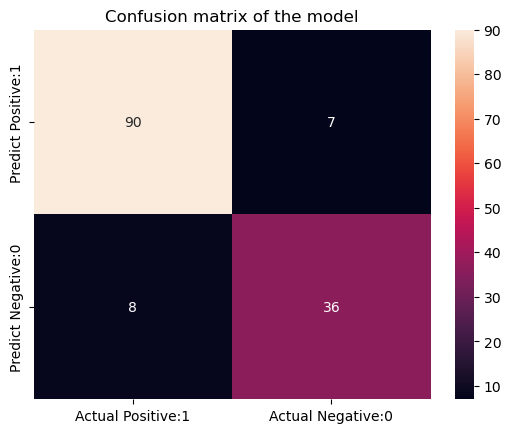

In [21]:
def cm(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                  index=['Predict Positive:1', 'Predict Negative:0'])
    sns.heatmap(cm_matrix, annot=True)
    
cm(y_test, y_pred)
plt.title('Confusion matrix of the model')

* We can set the lower threshold to predict 1 or 0 to reduce the number of False Negatives, as an example. In this example I set threshold equals 0.7 and get recall 0.96. And also good result in presicion: 0.88. (These results can be a little bit different on the image)

<p id='7'><h3><b>Test data preparation</b></h3></p>

* We also need to load and prepare our test data to make predictions on it

In [22]:
test_dir  = Path('/kaggle/input/iuss-mlh-2023/complete_set/testing_set')

data_list = []

folder_path = '/kaggle/working'
folder_path = os.path.join(folder_path, "testing_set")
if not os.path.exists(folder_path): os.mkdir(folder_path)


index = 1
for img in sorted(test_dir.glob('*.png')):
    if "mask" not in str(img):
        print(str(img))
        img_mask = Path(str(img)[:-4] + '_mask.png')
        try:
            res = apply_mask(Image.open(img), Image.open(img_mask))
            res = Image.fromarray(res)
            res.save(f'{folder_path}/picture{index}.png')
        except Exception as e:
            print("Have problems with the", str(img_mask)[:-4] + '_' + str(i))
            print("Error:", e)
        
        image = cv2.imread(f'{folder_path}/picture{index}.png')
        image = cv2.resize(image, (224, 224))
        data_list.append(image)
                
        index += 1

/kaggle/input/iuss-mlh-2023/complete_set/testing_set/P001.png
/kaggle/input/iuss-mlh-2023/complete_set/testing_set/P002.png
/kaggle/input/iuss-mlh-2023/complete_set/testing_set/P003.png
/kaggle/input/iuss-mlh-2023/complete_set/testing_set/P004.png
/kaggle/input/iuss-mlh-2023/complete_set/testing_set/P005.png
/kaggle/input/iuss-mlh-2023/complete_set/testing_set/P006.png
/kaggle/input/iuss-mlh-2023/complete_set/testing_set/P007.png
/kaggle/input/iuss-mlh-2023/complete_set/testing_set/P008.png
/kaggle/input/iuss-mlh-2023/complete_set/testing_set/P009.png
/kaggle/input/iuss-mlh-2023/complete_set/testing_set/P010.png
/kaggle/input/iuss-mlh-2023/complete_set/testing_set/P011.png
/kaggle/input/iuss-mlh-2023/complete_set/testing_set/P012.png
/kaggle/input/iuss-mlh-2023/complete_set/testing_set/P013.png
/kaggle/input/iuss-mlh-2023/complete_set/testing_set/P014.png
/kaggle/input/iuss-mlh-2023/complete_set/testing_set/P015.png
/kaggle/input/iuss-mlh-2023/complete_set/testing_set/P016.png
/kaggle/

In [23]:
print(len(data_list))
print(data_list[0].shape)

100
(224, 224, 3)


* As always show several examples to be sure that I have the images in the right format

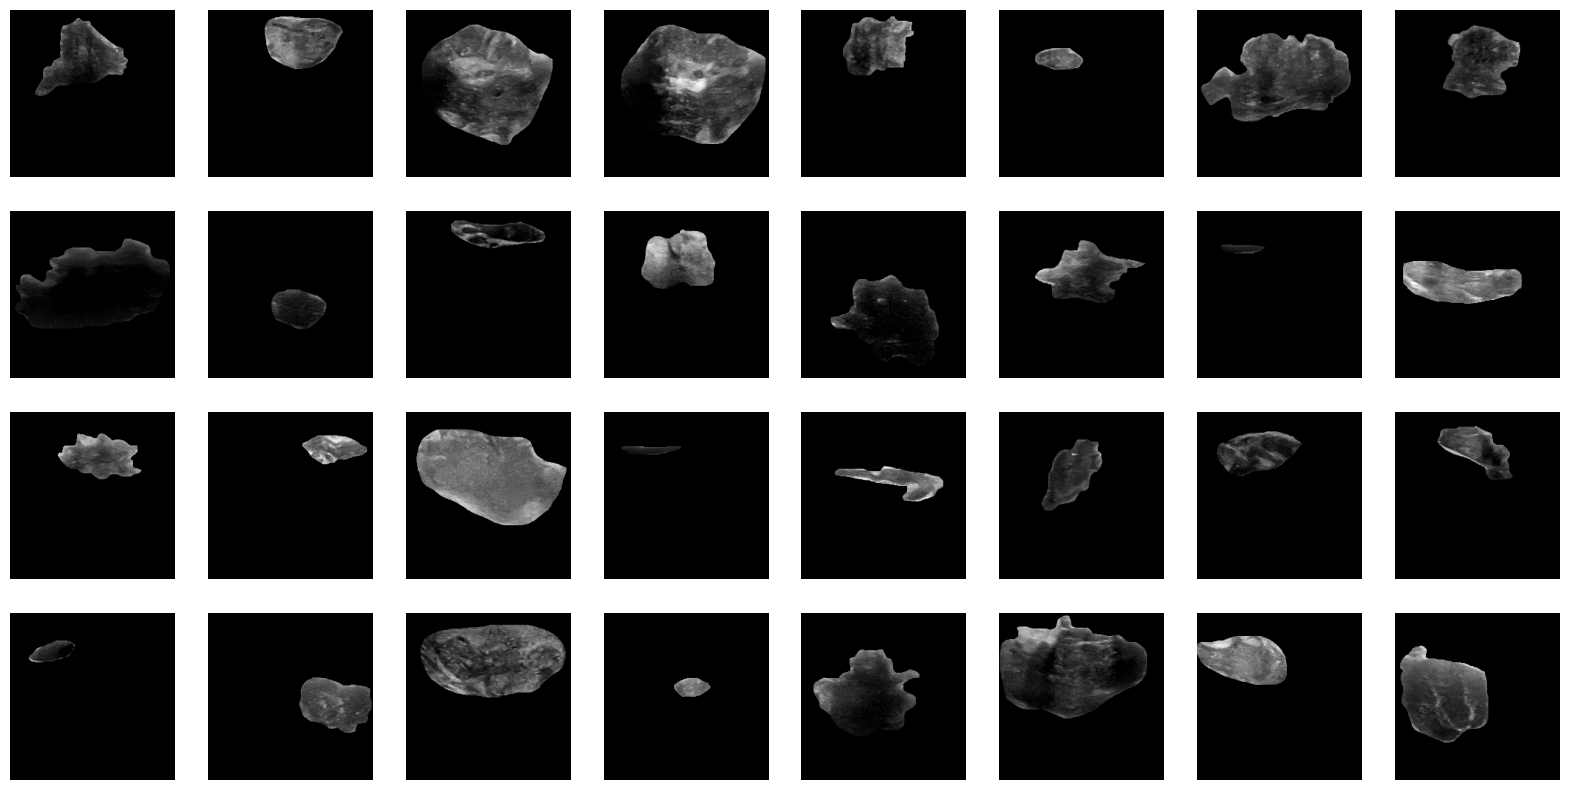

In [24]:
def plot_unlabeled(data: list, rows: int, cols: int, figsize: tuple):
    count = 0
    f, ax = plt.subplots(rows, cols, figsize=figsize)
    for i in random.sample(range(0, len(data)), rows*cols):
        img = data[i]
        ax[count//cols, count%cols].imshow(img, cmap='gray')
        ax[count//cols, count%cols].axis('off')
        ax[count//cols, count%cols].set_aspect('auto')
        count += 1
    plt.show()
    
plot_unlabeled(data_list, 4, 8, (20,10))

In [25]:
data_list = np.array(data_list, dtype="float32") / 255.0

<p id='8'><h3><b>Making predictions</b></h3></p>

In [26]:
probability = custom_model.predict(data_list, batch_size=8, verbose=1)
probability = (probability - probability.min()) / (probability.max() - probability.min())
probability

13/13 [==============================] - 2s 129ms/step


array([[0.9975984 ],
       [0.99870235],
       [0.9995188 ],
       [0.        ],
       [0.99568075],
       [0.04036457],
       [0.92354035],
       [0.03334655],
       [0.9972088 ],
       [0.99835545],
       [0.07395566],
       [0.26742685],
       [0.96332467],
       [0.26308236],
       [0.03031696],
       [0.21690427],
       [0.11035496],
       [0.99825364],
       [0.2942142 ],
       [0.02655261],
       [0.9374643 ],
       [0.11187134],
       [0.99973804],
       [0.9989441 ],
       [0.03402825],
       [0.21518213],
       [0.99985284],
       [0.9976296 ],
       [0.9993954 ],
       [0.7179222 ],
       [0.8228442 ],
       [0.7521895 ],
       [0.888227  ],
       [0.93417174],
       [0.9945812 ],
       [0.00384255],
       [0.82258046],
       [0.9972213 ],
       [0.9174902 ],
       [0.59046257],
       [0.08027367],
       [0.993584  ],
       [0.9983702 ],
       [0.01566094],
       [0.96351755],
       [0.99954736],
       [0.18414323],
       [0.062

In [27]:
submission = pd.DataFrame(columns=['Id', 'Predicted'])
submission['Id'] = ['T001', 'T002', 'T003', 'T004', 'T005', 'T006',
                    'T007', 'T008', 'T009', 'T010', 'T011', 'T012',
                    'T013', 'T014', 'T015', 'T016', 'T017', 'T018',
                    'T019', 'T020', 'T021', 'T022', 'T023', 'T024',
                    'T025', 'T026', 'T027', 'T028', 'T029', 'T030',
                    'T031', 'T032', 'T033', 'T034', 'T035', 'T036',
                    'T037', 'T038', 'T039', 'T040', 'T041', 'T042',
                    'T043', 'T044', 'T045', 'T046', 'T047', 'T048',
                    'T049', 'T050', 'T051', 'T052', 'T053', 'T054',
                    'T055', 'T056', 'T057', 'T058', 'T059', 'T060',
                    'T061', 'T062', 'T063', 'T064', 'T065', 'T066',
                    'T067', 'T068', 'T069', 'T070', 'T071', 'T072',
                    'T073', 'T074', 'T075', 'T076', 'T077', 'T078',
                    'T079', 'T080', 'T081', 'T082', 'T083', 'T084',
                    'T085', 'T086', 'T087', 'T088', 'T089', 'T090',
                    'T091', 'T092', 'T093', 'T094', 'T095', 'T096',
                    'T097', 'T098', 'T099', 'T100']

submission['Predicted'] = probability
submission.to_csv('submission.csv', index=False)
submission = pd.read_csv('submission.csv')

submission

,Id,Predicted
0,T001,0.997598
1,T002,0.998702
2,T003,0.999519
3,T004,0.000000
4,T005,0.995681
...,...,...
95,T096,0.998893
96,T097,0.356837
97,T098,0.303620
98,T099,0.983124


* Finally I scored ~ 0.87 and I think it's not bad result for the data I have.